### Emircan Akyüz
Bu çalışma Emircan Akyüz tarafından yapılmıştır. Çalışma iki bölümden oluşmaktadır: **veri analizi ve ön işleme** ile **model geliştirilmesi.**

## 1-) Veri Analizi ve Ön İşleme

In [835]:
# Kütüphaneleri import edelim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [740]:
df = pd.read_excel("data.xlsx")
df.head() #.head() veri setimizin ilk 5 sütununu bize gösterir

,company_code,document_number,description,payment_type,amount,currency_code,transaction_type,seller_number,customer_number,main_account
0,1504,4200004825,EF7789421YORUMAJANSPAZARLAMAITHALATVET-FATURAB...,H,400000.0,TRY,NEFT,NaN,1.200110e+09,NaN
1,1504,4200004824,SEBNEMBATI-GUROLBATIODAKEGI,H,21000.0,TRY,NMSC,NaN,1.200120e+09,NaN
2,1504,4200004826,ANADOLUISLETMELERITI-KEN,H,72000.0,TRY,NMSC,NaN,1.200118e+09,NaN
3,1504,4200004828,FUARCILIKLTD.STI.-FUARCILIKODEMET,H,24000.0,TRY,NMSC,NaN,1.200100e+09,NaN
4,1504,4200004827,INT-HVL-BAŞAKŞEHİRCHODEME-KARSILIKSIZ-MEDYA9IL...,H,158000.0,TRY,NTRF,NaN,1.200106e+09,NaN


Ön işleme adımlarına başlamadan önce temel analiz yapalım. Sütunların bizlere tahminsel olarak ne çağrıştırdığına göz atalım. Buradaki bilgilerin tahminsel olduğunu tekrar belirtelim.
- **company_code:** Şirketlere atanan bir ID adresi olarak düşünebiliriz.
- **document_number:** Şirketlerin gerçekleştirdiği işlem sonrasında oluşturulan belgenin numarası.
- **description:** Gerçekleştirilen işlem ile ilgili kısa bir açıklama.
- **payment_type:** Bu sütun ödeme türünü ifade ediyor. S: Slip benzeri ya da kredi kartı ile ilgili bir kısaltma olabilir. H: Nakitle ilgili bir kısaltma olabilir.
- **amount:** Gerçekleştirilen işlem miktarı.
- **currency_code:** İşlemin hangi para biriminde gerçekleştirildiğini belirtir. 
- **transaction_type:** Bankacılık sektöründeki mesaj formatlarını içeriyor. Örnek: NTAX, vergi ödemelerini ifade etmektedir. 
- **seller_number:** Çıktı sınıfı
- **customer_number:** Çıktı sınıfı
- **main_account:** Çıktı sınıfı

Bu çalışmada çıktılarımız seller_number, customer_number ve main_account olarak verilmiş. Bu çıktılar veri setinde sütunlar olarak ifade edilmiş ve sütun içeriklerine ise satış numarasını ve yahut müşteri numarasını temsil eden nümerik değerler girilmiş. **Daha detaylandıracak olursak çıktı sınıfları şuna benzer bir yapıya sahip olmuş oluyor.**

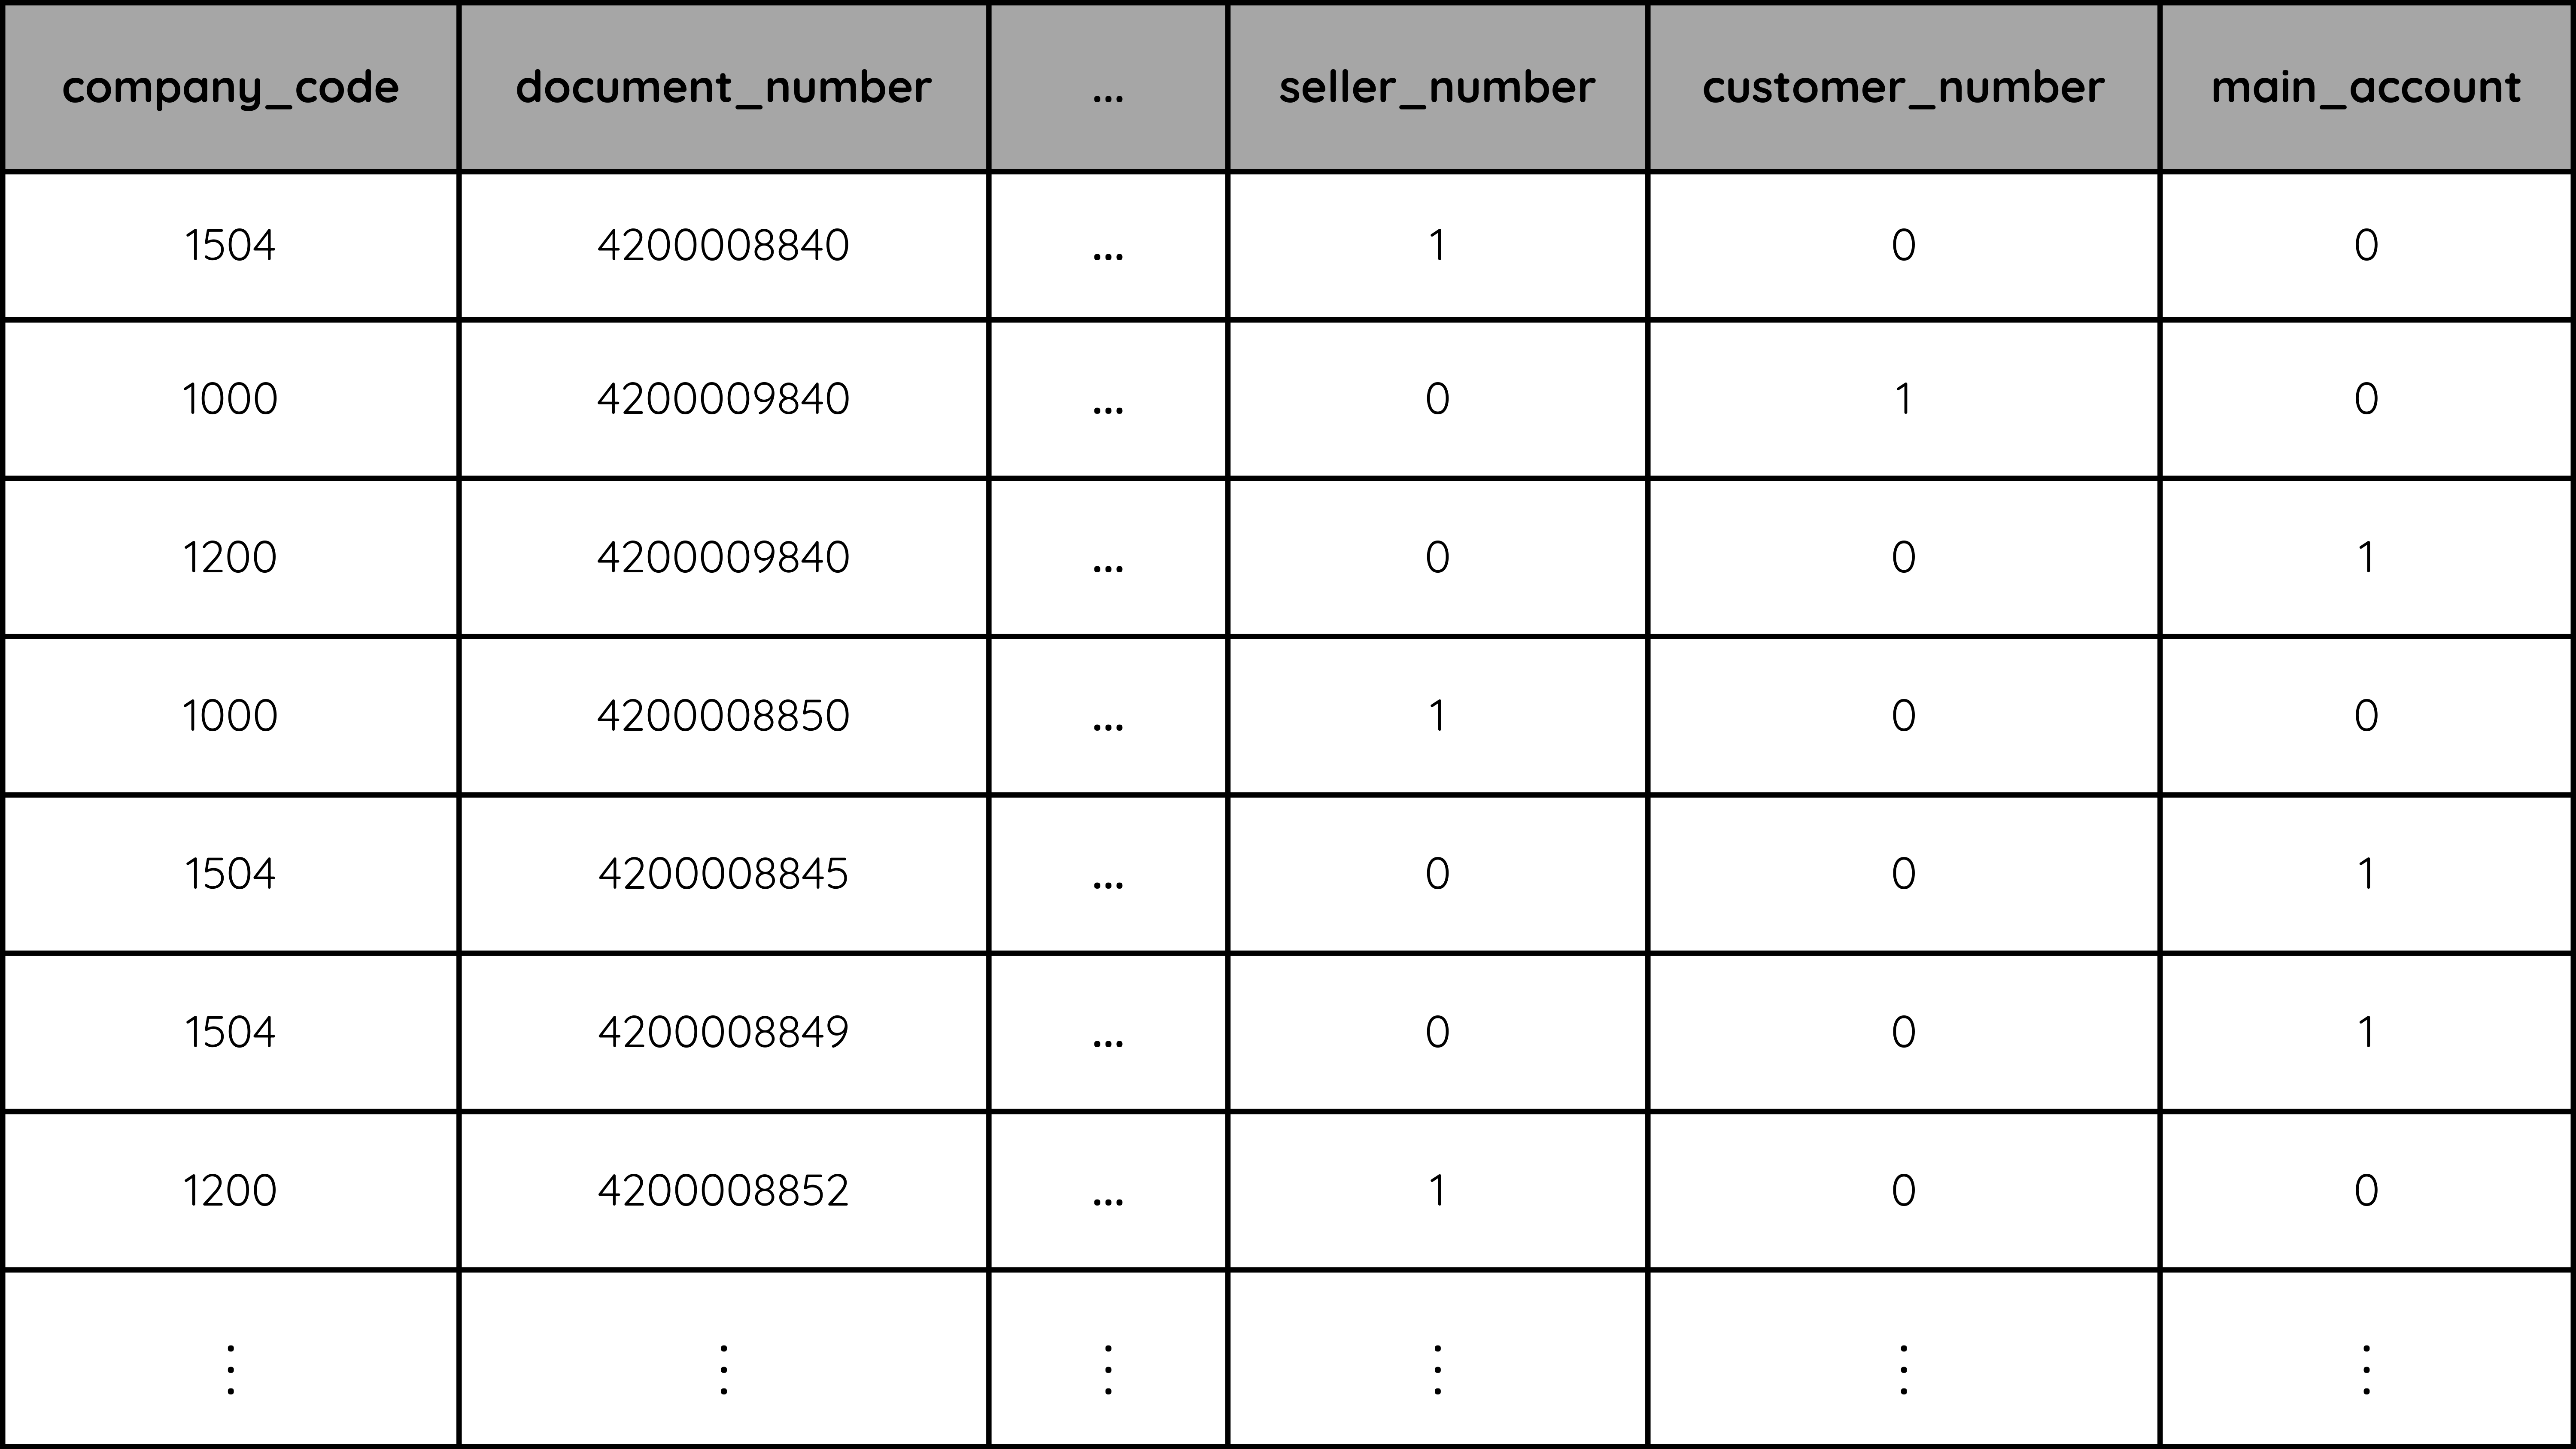

Bu sütunlarda bulunan değerler eksik veri olarak da yorumlanmaya müsait gibi duruyor fakat bu sütunlarda şöyle bir fark var: sütunlardaki değerler tekrar eden ifadeler barındırdığından ötürü çeşitli numaralandırılma yöntemleri kullanılarak yazılmışa benziyor. Örnek vermek gerekirse "1950005053" ifadesinde 195 belli bir anlam taşıyan değer olabilir (vergi ücretlendirmesi vb). Dolayısıyla bu eksik verileri sütunun ortalaması ya da medyanı gibi değerleri kullanarak dolduramayız çünkü anlamlı bir sonuç çıkmayacaktır. Dolayısıyla bu sütunlarda eksik veri analizi yapmayacağız ve dodurma işlemi gerçekleştirmeyeceğiz onun yerine bu kısmı görseldekine benzer bir yapıya çevirmemiz gerekiyor. Bunun için verisetine output isminde yeni bir sütun ekleyeceğiz ve sütunları 0, 1 ve 2 olarak dolduracağız. **Bu aşamada 0: seller_number sınıfını, 1:customer_number sınıfını ve 2:main_account sınıfını temsil edecek.**

In [743]:
# output sütunu oluşturma
df["output"] = 0 # output adında yeni bir sütun oluşturuyoruz ve tüm değerleri 0 ile dolduruyoruz.

In [744]:
# Bu işlemi yapmak için bir fonksiyon oluşturalım.
# 0: seller_number
# 1: customer_number
# 2: main_account
def output_values(df, target_column, output_column, output_value):
    # Eğer output_column sütunu yoksa oluştur
    if output_column not in df.columns:
        df[output_column] = None
    
    # Sütunu for ile dolaş
    for index, value in enumerate(df[target_column]):
        if pd.notna(value):
            df.loc[index, output_column] = output_value # ilgili satır boş değil ise çıktı değerini ata
        else:
            continue # ilgili satır boş ise diğer satıra geç

In [745]:
# önce customer_number sütununu sonra ise main_account sütununu ilgili sınıf değerleri ile dolduruyoruz. 
output_values(df, "customer_number", "output", 1)
output_values(df, "main_account", "output", 2)

Bu değişiklikleri yaptıktan sonra veri setimize bir kez daha bakacak olursak output sütunundaki çıktılarımızın, çıktı sınıfları (seller_number, customer_number, main_account) baz alınarak 0,1,2 olarak sınıflandırıldığını görebiliriz.

In [747]:
df.head(50)

,company_code,document_number,description,payment_type,amount,currency_code,transaction_type,seller_number,customer_number,main_account,output
0,1504,4200004825,EF7789421YORUMAJANSPAZARLAMAITHALATVET-FATURAB...,H,400000.00,TRY,NEFT,NaN,1.200110e+09,NaN,1
1,1504,4200004824,SEBNEMBATI-GUROLBATIODAKEGI,H,21000.00,TRY,NMSC,NaN,1.200120e+09,NaN,1
2,1504,4200004826,ANADOLUISLETMELERITI-KEN,H,72000.00,TRY,NMSC,NaN,1.200118e+09,NaN,1
3,1504,4200004828,FUARCILIKLTD.STI.-FUARCILIKODEMET,H,24000.00,TRY,NMSC,NaN,1.200100e+09,NaN,1
4,1504,4200004827,INT-HVL-BAŞAKŞEHİRCHODEME-KARSILIKSIZ-MEDYA9IL...,H,158000.00,TRY,NTRF,NaN,1.200106e+09,NaN,1
5,1504,4200004830,CEPSUBE-HVL-SEAKTOPRAPORODEMESI-SELINKILIC,H,2932.84,TRY,NTRF,NaN,1.969002e+09,NaN,1
6,1504,4200004829,016716297369ISTANBULAIFAHOLDINGANONIMSIRKETITC...,S,3300000.00,TRY,NTRF,3.200200e+09,NaN,NaN,0
7,1504,4200004823,THEHESABAHAVALEKOMISYONU-KOMTCKN:VKN:,S,55.46,TRY,NTRF,NaN,NaN,7.800150e+09,2
8,1504,4200004831,10/09/2024CEKTAHSILATIUCRETITCKN:VKN:,S,44.24,TRY,NCHG,NaN,NaN,7.800150e+09,2
9,1504,4200004782,4310NOVARALASYONVELLIK-OBA2024000,H,182180.78,TRY,NEFT,NaN,1.200118e+09,NaN,1


In [748]:
# Veri setimizin genel durumuna bakalım
df.info() #.info() veri setimiz hakkında temel bilgileri tablo olarak sunar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_code      200 non-null    int64  
 1   document_number   200 non-null    int64  
 2   description       200 non-null    object 
 3   payment_type      200 non-null    object 
 4   amount            200 non-null    float64
 5   currency_code     200 non-null    object 
 6   transaction_type  200 non-null    object 
 7   seller_number     109 non-null    float64
 8   customer_number   58 non-null     float64
 9   main_account      33 non-null     float64
 10  output            200 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 17.3+ KB


Veri setimizi pandas kullanarak içeri aktardığımız için türü Data Frame olarak karşımıza çıkıyor. 11 (normalde 10 sütun output sınıfı ile 11) sütun 200 satır olan veri setimizin dörder sütunu object türünde iken diğer sütunlar numeric bir yapıdadır. seller_number, customer_number ve main_account sütunlarındaki null olmayan değerlerin toplamı 200 yapmaktadır. Daha detaylı açıklayacak olursak veri setimiz çeşitli finansal işlemlerden oluşmakta ve bu işlemler seller_number (0), customer_number (1) ve main_account (2) olarak sınıflandırılmış diyebiliriz. Yukarıdaki tabloda görebileceğimiz üzere veri setimiz sadece nümerik türlerden oluşmuyor. Object olarak adlandırılmış olan verilerin String değerler olduğunu biliyoruz dolayısıyla bu değerleri sayısal bir formata çevirmeliyiz aksi takdirde model eğitimi sürecinde hatalar ile karşılaşabiliriz. Makine öğrenmesi (ML) algoritmalarının kategorik verilerde hata vermesinin nedeni, bu algoritmaların iç yapısındaki sayısal hesaplamalara dayanmaktadır. String veya kategorik veriler, algoritmaların matematiksel işlemler yapmasını engelleyeceğinden hatalara neden olur. 

In [750]:
# Veri setimizdeki eşsiz (unique) değerlere göz atalım.
company_code_unique = df.company_code.unique() #.unique() fonksiyonu bizlere o sütun içerisinde kaç adet eşsiz değer olduğunu gösermektedir.
payment_type_unique = df.payment_type.unique()
transaction_type_unique = df.transaction_type.unique()

In [751]:
print(f" company_code unique değerleri: {company_code_unique}\n payment_type unique değerleri: {payment_type_unique}\n transaction_type unique değerleri: {transaction_type_unique}")

 company_code unique değerleri: [1504 1501 1000 1200 1512]
 payment_type unique değerleri: ['H' 'S']
 transaction_type unique değerleri: ['NEFT' 'NMSC' 'NTRF' 'NCHG' 'NCHK' 'NTDP' 'NVRM' 'NTAX']


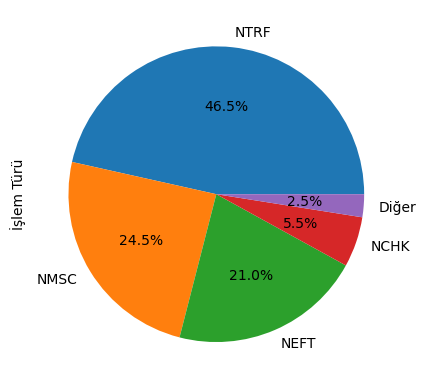

In [752]:
# Veri setimizi görseller ile temsil etmek hangi özelliklerin (features) daha baskın olduğunu bizlere daha okunabilir sunmaktadır.
counts = df.transaction_type.value_counts()
counts['Diğer'] = counts[counts < 5].sum()  # 5'ten küçük dilimleri toplayalım
counts = counts[counts >= 5]  # Sadece büyük dilimleri bırakalım
counts.plot(
    kind="pie", 
    autopct="%.1f%%"
)
plt.ylabel("İşlem Türü");
plt.show()

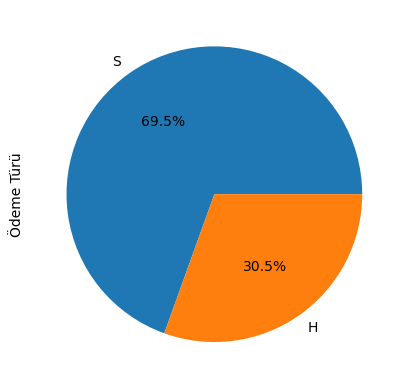

In [753]:
df.payment_type.value_counts().plot(kind= "pie", autopct = "%.1f%%")
plt.ylabel("Ödeme Türü");

### Eksik Veri Analizi

In [755]:
df.isnull() #.isnull() fonksiyonu tablodaki null kısımlara "True" null olmayan kısımlara "False" yazar 

,company_code,document_number,description,payment_type,amount,currency_code,transaction_type,seller_number,customer_number,main_account,output
0,False,False,False,False,False,False,False,True,False,True,False
1,False,False,False,False,False,False,False,True,False,True,False
2,False,False,False,False,False,False,False,True,False,True,False
3,False,False,False,False,False,False,False,True,False,True,False
4,False,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
195,False,False,False,False,False,False,False,False,True,True,False
196,False,False,False,False,False,False,False,False,True,True,False
197,False,False,False,False,False,False,False,False,True,True,False
198,False,False,False,False,False,False,False,False,True,True,False


In [756]:
df.isnull().sum() #.isnull() fonksiyonunu .sum() ile kullandığımızda ise tüm sütunlarda false değerleri toplanır ve tablo olarak sunulur 

company_code          0
document_number       0
description           0
payment_type          0
amount                0
currency_code         0
transaction_type      0
seller_number        91
customer_number     142
main_account        167
output                0
dtype: int64

Çıktı olarak seçeceğimiz sınıflar haricinde eksik bir değer olmadığını görüyoruz. Eğer ki veri setimizde eksik değerler bulunan sütunlar olsaydı eksik değerler yerine ilgili sütunun ortalamasını ya da medyanını yazacaktık (Eğer ki veri setimiz gaussian bir dağılıma sahipse ortalamayı veya medyanı yazabiliriz fakat veri setimiz çarpık bir dağılıma sahipse o zaman ortalamayı yazamayız çünkü ortalama değeri anormal bir değere sahip olabilir. Dolayısıyla çarpık bir dağılımda eksik verileri doldurmak istersek medyan değerini kullanırız). Eğer ki null değerleri doldurmadan ön işlemeyi tamamlarsak hatalı bir veri seti ile çalışacağımızdan modelimiz (bazı algoritmalar eksik değerlerle başa çıkabilir ve onları otomatik olarak işleyebilir) öğrenme işlemi gerçekleştiremeyecektir. 

### Kategorik Verilerin Sayısal Verilere Çevrimi

Veri setimizde 4 adet kategorik sütun görüyoruz bunlar: description, currency_code, transaction_type, payment_type. Bu sütunlardan transaction_type ve payment_type sütunlarını sayısal verilere çevireceğiz. Diğer sütunlar çıktıya etki eden bir yapıya sahip olmadığı için çevrim işlemi gerçekleştirmeyeceğiz. description sütunu gerçekleştirilen işlemlerin özet halinde açıklamasını barındırıyor. Bu sütunu eğitim süresinde kullanamdığımızdan ötürü çevirmeyeceğiz ayrıca currency_code sütunu da para birimini ifade etmektedir. Veri setindeki tüm işlemlerin gerçekleştirildiği para birimleri TRY olduğu için çıktıya herhangi bir etkisi olmamaktadır.

In [760]:
df.payment_type.unique() # dönüşüm gerçekleştireceğimiz unique değerlere bakalım

array(['H', 'S'], dtype=object)

In [761]:
df["payment_type"] = df.payment_type.map({'H': 0,
                                          'S': 1}) # dönüşümü gerçekleştirelim

In [762]:
df.transaction_type.unique() # dönüşüm gerçekleştireceğimiz unique değerlere bakalım

array(['NEFT', 'NMSC', 'NTRF', 'NCHG', 'NCHK', 'NTDP', 'NVRM', 'NTAX'],
      dtype=object)

In [763]:
df["transaction_type"] = df.transaction_type.map({"NEFT":0,
                        "NMSC":1,
                        "NTRF":2,
                        "NCHG":3,
                        "NCHK":4,
                        "NTDP":5,
                        "NVRM":6,
                        "NTAX":7}) # dönüşümü gerçekleştirelim

### Aykırı Değer Analizi ve İşlenmesi

Aykırı değerler, bir veri setinde diğer gözlemlerden çok farklı olan veri noktalarıdır. Makine öğrenmesi modellerinde aykırı değerler, model preformansının negatif anlamda etkilenmesine, istatiksel dağılımın bozulmasına ve modelin kötü kararlar vererek genelleştirme kabiliyetinin azalmasına neden olabilir. Aykırı değerler titiz bir şekilde analiz edilmeli ve gerekirse veri setinden çıkarılmalıdır. Burada kullandığım titiz ifadesini şu şekilde düşünmeliyiz, belirleyeceğimiz alt ve üst sınır gereğinden daha az olursa veri setinin yarısına yakını silinebilir. Gereğinden fazla olur ise aykırı değerlerin çoğunu tespit edemeyebiliriz. Projelerin çoğunda aykırı değerler tespit edilir ve veri setinden çıkarılır. Fakat bu değerlerin medyanla değiştirilmesi de ayrı bir seçenektir. Biz veri setimizin boyutunda bir azalma olmaması için aykırı değerleri ilgili sütunun medyan değerleri ile değiştireceğiz.

In [766]:
outlier_columns_list = ["amount","document_number"] # kategorik özniteliklerde aykırı değer aranmaz dolayısıyla sadece nümerik olanları alıyoruz. Ayrıca "document_number" ifadesini girdi olarak almayı düşünmüyorum fakat örnek olması amacıyla işleme sokuyorum.
df_outlier = df.loc[:,outlier_columns_list]
df_outlier.head()

,amount,document_number
0,400000.0,4200004825
1,21000.0,4200004824
2,72000.0,4200004826
3,24000.0,4200004828
4,158000.0,4200004827


Sütun: amount
Aykırı değer indeksleri (Üst): [  6  15  18  21  34  35  46  47  57  86  87 139 141 147 152 153 154 172
 173 174 193 194]
Aykırı değer indeksleri (Alt): []


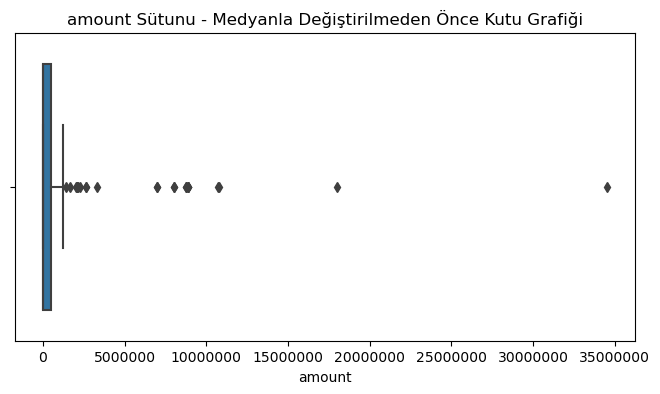

Sütun: document_number
Aykırı değer indeksleri (Üst): []
Aykırı değer indeksleri (Alt): []


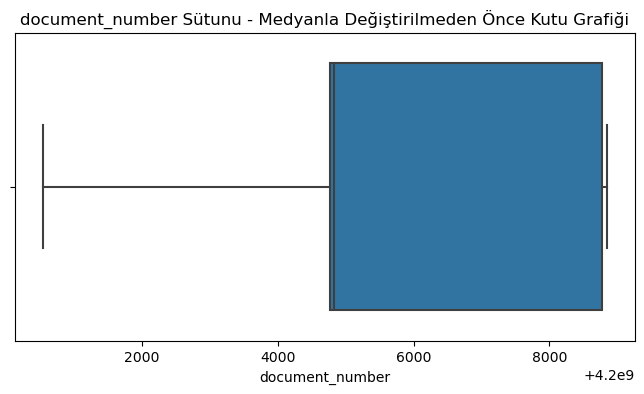

In [767]:
# IQR yöntemi ile aykırı değer tespiti ve işlenmesi
for column in outlier_columns_list:
    Q1 = np.percentile(df.loc[:, column], 25)  # 1. Çeyreklik
    Q3 = np.percentile(df.loc[:, column], 75)  # 3. Çeyreklik
    IQR = Q3 - Q1  # Çeyrekler arası genişlik
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    upper = np.where(df.loc[:,column] >= upper_bound)[0] # üst sınır
    lower = np.where(df.loc[:,column] <= lower_bound)[0] # alt sınır

    print(f"Sütun: {column}")
    print(f"Aykırı değer indeksleri (Üst): {upper}")
    print(f"Aykırı değer indeksleri (Alt): {lower}")

    # Kutu grafiği (medyanla değiştirilmeden önce)
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f"{column} Sütunu - Medyanla Değiştirilmeden Önce Kutu Grafiği")
    plt.ticklabel_format(style='plain', axis='x') 
    plt.show()

    # Aykırı değerleri sütunun medyanı ile değiştir
    median = df.loc[:, column].median()
    df.loc[upper, column] = median
    df.loc[lower, column] = median

In [768]:
df.head(50)
# 6. sıradaki amount değerine bakacak olursak en başlardaki görüntülediğimiz tablodaki değerden daha farklı bir değere,
# yani o sütunun medyan değerine sahip olduğunu görebiliriz. 

,company_code,document_number,description,payment_type,amount,currency_code,transaction_type,seller_number,customer_number,main_account,output
0,1504,4200004825,EF7789421YORUMAJANSPAZARLAMAITHALATVET-FATURAB...,0,400000.00,TRY,0,NaN,1.200110e+09,NaN,1
1,1504,4200004824,SEBNEMBATI-GUROLBATIODAKEGI,0,21000.00,TRY,1,NaN,1.200120e+09,NaN,1
2,1504,4200004826,ANADOLUISLETMELERITI-KEN,0,72000.00,TRY,1,NaN,1.200118e+09,NaN,1
3,1504,4200004828,FUARCILIKLTD.STI.-FUARCILIKODEMET,0,24000.00,TRY,1,NaN,1.200100e+09,NaN,1
4,1504,4200004827,INT-HVL-BAŞAKŞEHİRCHODEME-KARSILIKSIZ-MEDYA9IL...,0,158000.00,TRY,2,NaN,1.200106e+09,NaN,1
5,1504,4200004830,CEPSUBE-HVL-SEAKTOPRAPORODEMESI-SELINKILIC,0,2932.84,TRY,2,NaN,1.969002e+09,NaN,1
6,1504,4200004829,016716297369ISTANBULAIFAHOLDINGANONIMSIRKETITC...,1,23844.50,TRY,2,3.200200e+09,NaN,NaN,0
7,1504,4200004823,THEHESABAHAVALEKOMISYONU-KOMTCKN:VKN:,1,55.46,TRY,2,NaN,NaN,7.800150e+09,2
8,1504,4200004831,10/09/2024CEKTAHSILATIUCRETITCKN:VKN:,1,44.24,TRY,3,NaN,NaN,7.800150e+09,2
9,1504,4200004782,4310NOVARALASYONVELLIK-OBA2024000,0,182180.78,TRY,0,NaN,1.200118e+09,NaN,1


### Korelasyon Analizi

Korelasyon analizi, iki veya daha fazla değişken arasındaki doğrusal ilişkinin yönünü ve derecesini ölçmek için kullanılan bir istatistiksel tekniktir. Yani iki değişkenin birlikte nasıl değiştiğini anlamamızı sağlar. Korelasyon değeri -1 ile 1 arasında değişmektedir. Negatif korelasyon öznitelikler (features) arasında ters orantı olduğunu ifade ederken pozitif korelasyon doğru orantı olduğunu ifade etmektedir. Korelasyonun gücü ise sayının büyüklüğü ile ilgilidir. Peki korelasyonun gücü nedir? Korelasyonun gücü ya da kuvveti, aralarındaki ilişinin ne kadar güçlü olduğunu ifade etmektedir. İki öznitelik arasındaki korelasyonun değeri 1 ise bu iki değişkeninde aynı yapıya ait olduğunu ve biri arttığı zaman aynı diğerinin de çok benzer şekilde arttığını ifade etmektedir. Bu örneğin benzerini -1 korelasyon sonucunda da düşünebiliriz, bu sefer ise iki öznitelik arasında ters orantılı olacak şekilde çok güçlü bir ilişki vardır. 0 korelasyon ise ilişki olmadığını belirtmektedir. Farklı korelasyon türleri olsa da en sık kullanılan **Pearson Korelasyonu** olarak bilinmektedir. Pearson korelasyonu, değişkenlerin sürekli yani sayısal olduğu durumlarda kullanılmaktadır.

In [771]:
# pearson korelasyon tüm nümerik sütunlarda kullanmak için veri setimizdeki nümerik sütunları alıyoruz
df_corr_list= ["company_code","document_number","payment_type","amount","transaction_type","output"]
correlation_matrix = df[df_corr_list].corr()

In [772]:
correlation_matrix

,company_code,document_number,payment_type,amount,transaction_type,output
company_code,1.000000,-0.801570,-0.402363,-0.011533,-0.007045,0.455029
document_number,-0.801570,1.000000,0.341772,0.051318,0.030022,-0.453427
payment_type,-0.402363,0.341772,1.000000,-0.075665,0.229712,-0.349164
amount,-0.011533,0.051318,-0.075665,1.000000,0.056061,0.078959
transaction_type,-0.007045,0.030022,0.229712,0.056061,1.000000,0.327281
output,0.455029,-0.453427,-0.349164,0.078959,0.327281,1.000000


Burada company_code ifadesinin çıktımızla güçlü sayılabilecek bir doğru orantısı olduğunu görüyoruz. document_number sütunu da aynı şekilde gibi duruyor fakat bu sonuç rastgele çıkmış olabilir (document_number ile ilgili üst markdownlarda söylediklerimden ötürü). Bunlar haricinde payment_type ve company_code arasında güçlü sayılabilecek bir ters orantı mevcut. Dolayısıyla bu iki öznitelik çıktımızı da etkileyen önemli bir diğer unsur oldu.

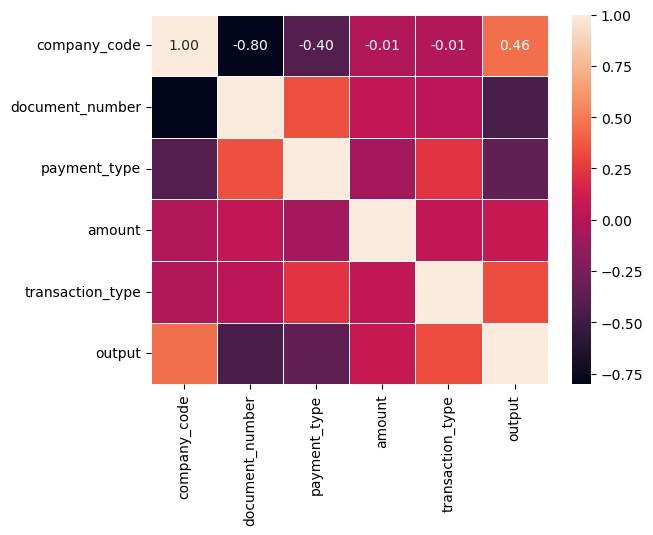

In [774]:
# heatmap ile görselleştirelim
sns.heatmap(correlation_matrix, annot = True, fmt=".2f", linewidths=.7)
plt.show()

### Veri Setimizi "X" ve "y" Olarak Ayırma

**X:** girdilerimizi oluşturacağımız değişken. Girdiler arasında anlamlı bir ifade olmadığı için **document_number ve description** sütunlarını almadım. Tüm hepsi aynı değer olduğu için çıktımıza bir etkisi olmayacak olan **currency_code** sütununu da dahil etmedim. Son olarak **seller_number, customer_number, main_account** sütunlarını çıktı sınıflarımız olduğu için almadım ve bunlar yerine daha pratik ve kullanışlı bir şekilde oluşturduğumuz **output** sütununu da **dahil etmedim.**

**y:** çıktı sınıfımızı oluşturacağımız değişken. **0: seller_number, 1: customer_number, 2: main_account** olarak temsil edilmektedir.

In [777]:
X = df[["company_code","payment_type","amount","transaction_type"]]

In [778]:
X.head()

,company_code,payment_type,amount,transaction_type
0,1504,0,400000.0,0
1,1504,0,21000.0,1
2,1504,0,72000.0,1
3,1504,0,24000.0,1
4,1504,0,158000.0,2


In [779]:
y = df[["output"]]

In [780]:
y.head()

,output
0,1
1,1
2,1
3,1
4,1


### Verilerin Ölçeklenmesi (Standardizasyon)

Verilerin standardizasyonu, farklı ölçekteki veri özelliklerini (feature) aynı ölçeğe getirmek için kullanılan bir yöntemdir ve verilerin ortalamasını 0, standart sapmasını ise 1 olacak şekilde yeniden ölçeklendirir. Bu dengeleme ML algoritmamızın öğrenme sürecini kolaylaştırır ve daha verimli bir eğitim süreci sağlar. Peki normalize edilmezse neler olur? Eğer bu veriler normalize edilmezse, büyük ölçekli değerler (örneğin gelir) model üzerinde daha büyük bir ağırlığa sahip olur ve modelin öğrenme sürecinde dengesizliklere neden olarak bozabilir. Ölçekleme işleminde nümerik veriler üzerinde bir ölçekleme yapıldığını yani kategorik veriler üzerinde bir işlem yapılmadığını da belirtelim.

In [783]:
scaler = StandardScaler()
scaler

StandardScaler()

In [784]:
X["amount"] = scaler.fit_transform(X[["amount"]])

In [785]:
X.head()

,company_code,payment_type,amount,transaction_type
0,1504,0,0.791053,0
1,1504,0,-0.479718,1
2,1504,0,-0.308717,1
3,1504,0,-0.469659,1
4,1504,0,-0.020363,2


## 2-) Model Geliştirilmesi

İlk bölümde analizlerimizi ve ön işleme adımlarını tamamladıktan sonra sıra model geliştirilmesi, train ve test süreçlerine geldi. Bu aşamada birçok ML çalışmasında kullanılan ve başarılı sonuçlar veren **Logistik Regression** algoritmasını kullanacağız ve train veri setimiz ile eğiteceğiz. Geliştirdiğimiz modelin performansını test veri seti ile farklı performans ölçütleri kullanarak analiz edeceğiz ve çalışmamızı noktalayacağız. 

### Eğitim Test Veri Seti Ayrımı

In [789]:
# case çalışması için dokümanda belirtildiği gibi 150, 50 şeklinde train ve test ayrımını gerçekleştiriyoruz. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)

In [790]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (150, 4)
X_test: (50, 4)
y_train: (150, 1)
y_test: (50, 1)


### Lojistik Regresyon ile Sınıflandırma

In [800]:
logreg = LogisticRegression()
logreg

LogisticRegression()

In [802]:
logreg.fit(X_train,y_train) # eğitimi .fit modülü ile gerçekleştiriyoruz.

LogisticRegression()

In [810]:
y_pred_prob = logreg.predict_proba(X_test) # .predict_proba ile test veri setindeki her durum için probabilistik olarak olasılıkları hesaplıyoruz

.predict_proba ile, test veri setinde (X_test) her bir satırdaki değerler hesaplanıyor ve bu hesaplar sonucu elde edilen tahminler probabilistik olarak okunuyor. Burada dikkat etmemiz gerken nokta, 0-1-2 olmak üzere üç adet çıktı sınıfımız olduğundan ötürü her sınıf için ayrı bir olasılık hesaplannması ve bu hesaplanan tahminlerin toplamının 1'e eşit olması. y_pred_proba değişkenimizi yazdırdığımız zaman bunu net bir şekilde görebiliyoruz. Peki bu üç değer arasından hangisi bizim tahmin edilen sınıfımız olacak? Bu üç tahmin değerinden en yüksek olanı bizim için tahmin edilen sınıf olarak seçilmiş anlamına gelmektedir. İlk tahmin değerleri için örnek verecek olursak 0: 0.26727397, 1: 0.02708017, 2: 0.70564586 şeklindedir. Yani eğittiğimiz logreg modeli X_test veri setimizin ilk satırındaki değerleri hesaplamış ve tahminin bu yönde olmuştur.

y_pred_prob

In [821]:
y_pred=np.argmax(y_pred_prob, axis=1) # tahminlerimizde en yüksek olasılığa sahip olan indis (0,1,2) seçiliyor. 
y_pred

array([2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1,
       0, 0, 0, 0, 0, 0], dtype=int64)

### Performans Ölçütleri

**Accuracy**

Accuracy score, bir sınıflandırma modelinin doğruluğunu ölçmek için kullanılan temel bir performans metriğidir ve modelin doğru tahmin ettiği veri noktalarının toplam veri noktalarına oranını ifade eder. Formülü **𝐴 𝑐 𝑐 𝑢 𝑟 𝑎 𝑐 𝑦 = 𝐷 𝑜 𝑔 𝑟 𝑢  𝑇 𝑎 ℎ 𝑚 𝑖 𝑛 𝑙 𝑒 𝑟 / 𝑇 𝑜 𝑝 𝑙 𝑎 𝑚  𝑉 𝑒 𝑟 𝑖  𝑁 𝑜 𝑘 𝑡 𝑎 𝑙 𝑎 𝑟 ı** şeklindedir. Değeri 0 ile 1 arasında değişir ve 1 mükemmel bir performansı temsil eder. Veri setindeki sınıflar dengeli olduğunda genellikle iyi bir performans göstergesidir. Ancak, sınıfların dengesiz olduğu durumlarda yanıltıcı olabilir, çünkü model çoğunluk sınıfını sürekli tahmin ederek yüksek doğruluk elde edebilir. Bu nedenle, dengesiz veri setlerinde precision, recall, F1-score gibi diğer metriklerle birlikte değerlendirilmesi daha doğru bir sonuç verir.

In [824]:
accuracy = accuracy_score(y_pred,y_test) # Tahmin ettiğimiz değerler ile test için hazırladığımız veri setinin karşılaştırılması sonucunda ortaya çıkan değerimize bakalım
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.88


**Confusion Matrix**

Confusion Matrix, makine öğrenmesi modellerinin sınıflandırma performansını değerlendirmek için kullanılan bir tablodur ve gerçek değerler ile modelin tahmin ettiği değerler arasındaki ilişkiyi gösterir. Matris, dört temel bileşenden oluşur: **True Positives (TP), doğru tahmin edilen pozitifler; True Negatives (TN), doğru tahmin edilen negatifler; False Positives (FP), yanlış pozitif tahminler; ve False Negatives (FN), yanlış negatif tahminler.** Satırlar gerçek sınıfları, sütunlar ise modelin tahmin ettiği sınıfları temsil eder.

F1-Score (Weighted): 0.8662068965517241
Confusion Matrix:
[[26  0  0]
 [ 0 12  0]
 [ 6  0  6]]


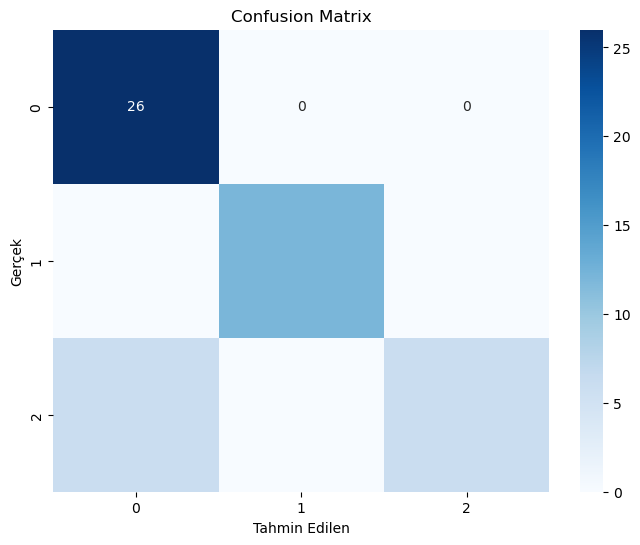

In [833]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix'i görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix ile modelimizin hangi sınıflarda iyi ya da kötü bir performans gösterdiğini net şekilde görebiliyoruz. Yukarıdaki matriksi inceleyecek olursak, 0 (seller_number) ve 1 (customer_number) sınıfları için hatasız bir tahmin yeteneğimiz varken 2 (main_account) sınıfında %50 bir başarı oranımız var.

**F1-Score**

1-score, makine öğrenmesinde bir modelin doğruluğunu ve duyarlılığını dengeleyen, özellikle dengesiz veri setlerinde faydalı olan bir performans ölçütüdür. Precision (kesinlik) ve Recall (duyarlılık) değerlerinin harmonik ortalaması olarak hesaplanır birden fazla metriği içeren bir yapısı olduğundan klasik accuracy hesabından daha güvenilirdir ve şu formülle ifade edilir: **𝐹 1 = 2 ⋅ 𝑃 𝑟 𝑒 𝑐 𝑖 𝑠 𝑖 𝑜 𝑛 ⋅ 𝑅 𝑒 𝑐 𝑎 𝑙 𝑙/𝑃 𝑟 𝑒 𝑐 𝑖 𝑠 𝑖 𝑜 𝑛 + 𝑅 𝑒 𝑐 𝑎 𝑙 𝑙**

In [840]:
# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.8662068965517241
